# 해야하는 일
1. 위험도를 정의. 위험도는 어떤 지점에서 일정 반경으로 일어난 사고의 횟수에 비례해야 한다.

한국교통연구원의 도로의 위험도
- 사고건수법 (Collective Risk) 사고 건수 / km
- 사고율법 (Individual Risk) 사고 건수 / (대수 x km) 
- 교통사고 심각도법 - 심각한 사고에 대해서 가중치
    - EPDO (대물피해 환산법)함수 = 12x사망사고 + 3x중상사고 + 1x물피사고

- 사고건수법을 예측하는 방향으로 가야할까? 흠...
2. 위험도와 관련이 있을 것과 같은 특징들을 찾아내야 한다.
- 이전 한달의 사고량
- 이전 3달의 평균 사고량
- 전년도 같은 달의 사고량
- 전년도 전체의 평균 사고량
- 500m 내의 공사의 개수
- 1000m 내의 공사의 개수
- 2000m 내의 공사의 개수
- 500m 내의 대규모 공사의 개수
- 1000m 내의 대규모 공사의 개수
- 2000m 내의 대규모 공사의 개수





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.ensemble import RandomForestRegressor


from pyproj import Transformer
import tqdm


In [ ]:
site_df = pd.read_csv("./outputs/공사_통합처리.csv")

acci_df = pd.read_csv("./data/사고지점_통합_2007_2023.csv")

risky_df = pd.read_csv("./outputs/안전도지점.csv")

gcs_to_utmk = Transformer.from_crs("EPSG:4326", "EPSG:5178", always_xy=True)

x, y = gcs_to_utmk.transform(site_df["경도"], site_df["위도"])

site_df["utmk_x"] = x
site_df["utmk_y"] = y

site_date = site_df["실착공일"].copy()
site_date.loc[site_df["실착공일"].isna()] = site_df.loc[site_df["실착공일"].isna(), "착공예정일"]

site_end_date = site_df["사용승인일"].copy()
site_end_date.loc[site_end_date.isna()] = site_date.loc[site_end_date.isna()]

site_date = site_date.apply(lambda x: str(int(x)))
site_end_date = site_end_date.apply(lambda x: str(int(x)))

site_df["year"], site_df["month"] = site_date.apply(lambda x: int(x[:4])), site_date.apply(
    lambda x: int(x[4:6])
)

site_df["end_year"], site_df["end_month"] = site_end_date.apply(lambda x: int(x[:4])), site_end_date.apply(
    lambda x: int(x[4:6])
)


In [3]:
site_df.head()

,대지위치,착공예정일,실착공일,사용승인일,대지면적(㎡),건축면적(㎡),건폐율(%),연면적(㎡),용적률산정용면적(㎡),용적률(%),...,경도,utmk_x,utmk_y,year,month,day,timestamp,labels,end_year,end_month
0,경기도 광명시 광명동 247-2,20060105.0,NaN,20060523.0,233.0,115.58,49.61,542.49,542.49,232.83,...,126.847712,942514.089615,1.941659e+06,2006,1,5,1.136452e+09,제2종근린생활시설,2006,5
1,경기도 광명시 옥길동 143-5,20060203.0,20060203.0,20060324.0,420.0,198.00,47.14,198.00,198.00,47.14,...,126.837606,941617.643457,1.941261e+06,2006,2,3,1.138957e+09,제2종근린생활시설,2006,3
2,경기도 광명시 옥길동 143-4,20060204.0,20060203.0,20060426.0,330.0,196.86,59.65,196.86,196.86,59.65,...,126.837737,941629.350295,1.941279e+06,2006,2,3,1.138957e+09,단독주택,2006,4
3,경기도 광명시 옥길동 143-5,20060207.0,20060206.0,20060508.0,677.0,203.65,30.08,297.55,297.55,43.95,...,126.837606,941617.643457,1.941261e+06,2006,2,6,1.139216e+09,제2종근린생활시설,2006,5
4,경기도 광명시 옥길동 52-8,20060208.0,20060207.0,20090107.0,254.0,132.02,51.98,199.50,199.50,78.54,...,126.840022,941830.674858,1.941174e+06,2006,2,7,1.139303e+09,제2종근린생활시설,2009,1


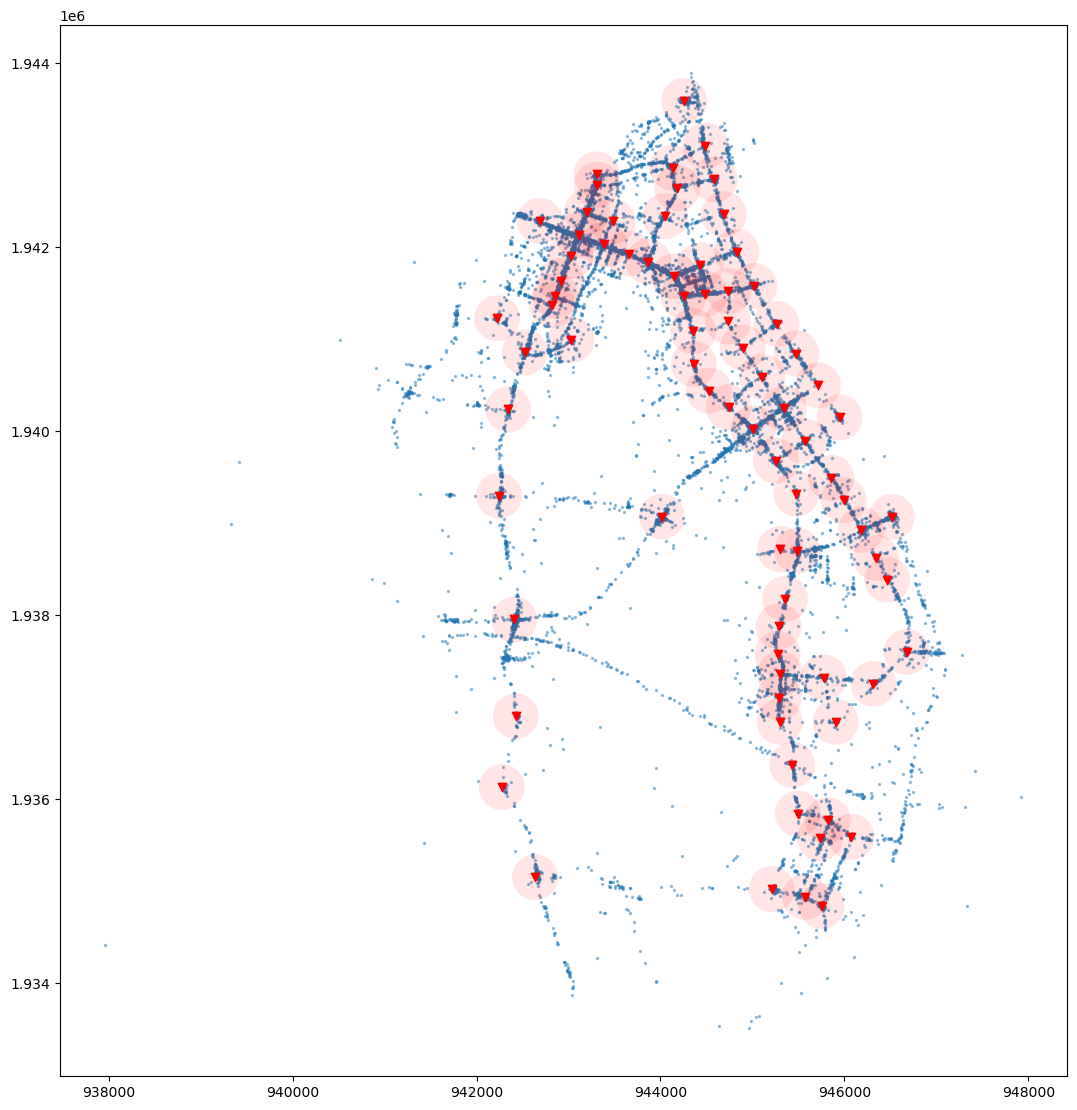

In [4]:
fig = plt.figure(num=1, figsize=(13, 17), clear=True)
ax = fig.subplots(1, 1)

ax.set_aspect("equal")

plt.scatter(risky_df["utmk_x"], risky_df["utmk_y"], c="red",marker="v",zorder=10)
plt.scatter(acci_df["utmk_x"], acci_df["utmk_y"], s=2, alpha=0.4)

for idx in risky_df.index:
    patch = Circle([risky_df.loc[idx, "utmk_x"], risky_df.loc[idx, "utmk_y"]], 250, fc=(1.0, 0.0, 0.0, 0.1))
    ax.add_artist(patch)

plt.show()

In [10]:
# 특징 생성하기
features = []
risky_info_df = []

label_dist = 250
acci_radii = [250, 500, 1000]


site_radii = list(range(500, 3001, 500))
large_site_df = site_df[site_df["labels"].apply(lambda x: "대규모" in x)]


def mask_distance(df, x, y, d=1000):
    mask = (df["utmk_x"] - x) ** 2 + (df["utmk_y"] - y) ** 2 <= d**2
    return mask


def mask_date(tgt_year, tgt_month, start_year, start_month, end_year, end_month, exclusive=False):
    mask = (tgt_year > start_year) | ((tgt_year == start_year) & (tgt_month >= start_month))
    if exclusive:
        mask = mask & ((tgt_year < end_year) | ((tgt_year == end_year) & (tgt_month < end_month)))
    else:
        mask = mask & (
            (tgt_year < end_year) | ((tgt_year == end_year) & (tgt_month <= end_month))
        )
    return mask


# 필요한 로직: 공사 기간을 고려해서 그 범위 안에 들어가는지 계산
# 근데 그냥 tgt_year, tgt_month를 스칼라로 쓰고 start_year, start_month, end_year, end_month를
# pd.Series로 써도 되더라.


for risky_idx in tqdm.tqdm(risky_df.index):
    risky_x, risky_y = risky_df.loc[risky_idx, ["utmk_x", "utmk_y"]]
    # 0. 사고율 계산용
    acci_within_label = acci_df[mask_distance(acci_df, risky_x, risky_y, label_dist)]
    # 1. 사고율 특징 계산용
    acci_within_radius = []
    # 1. 공사의 개수 계산용
    site_within_radius = []
    # 2. 대규모 공사의 개수 계산용
    large_site_within_radius = []

    for radius in acci_radii:
        acci_within_radius.append(acci_df[mask_distance(acci_df, risky_x, risky_y, radius)])

    for radius in site_radii:
        site_within_radius.append(site_df[mask_distance(site_df, risky_x, risky_y, radius)])
        large_site_within_radius.append(
            large_site_df[mask_distance(large_site_df, risky_x, risky_y, radius)]
        )

    for year in tqdm.trange(2012, 2024, leave=False):
        for month in range(1, 13):
            # 기간 내로 제한하면서 특징 만들기
            tmp_feature = []
            # 레이블
            tmp_feature.append(
                acci_within_label[
                    mask_date(
                        acci_within_label["year"],
                        acci_within_label["month"],
                        year,
                        month,
                        year,
                        month,
                        exclusive=False,
                    )
                ].shape[0]
            )

            # 이전 3달 평균
            for acci_w_df in acci_within_radius:
                tmp_feature.append(
                    acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 3 - 1) // 12,  # 4개월전
                            (month - 3 - 1) % 12 + 1,
                            year + (month - 1 - 1) // 12,  # 1개월전
                            (month - 1 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                    / 3
                )
            # 전년도 같은 달
            for acci_w_df in acci_within_radius:
                tmp_feature.append(
                    acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 12 - 1) // 12,  # 12개월전
                            (month - 12 - 1) % 12 + 1,
                            year + (month - 12 - 1) // 12,  # 12개월전
                            (month - 12 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                )
            # 전년도 전체 평균
            for acci_w_df in acci_within_radius:
                tmp_feature.append(
                    acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 24 - 1) // 12,  # 24개월전
                            (month - 24 - 1) % 12 + 1,
                            year + (month - 13 - 1) // 12,  # 12개월전
                            (month - 32 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                    / 12
                )
            # 이전 3년 전체 평균
            for acci_w_df in acci_within_radius:
                tmp_feature.append(
                    acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 48 - 1) // 12,  # 48개월전
                            (month - 48 - 1) % 12 + 1,
                            year + (month - 13 - 1) // 12,  # 13개월전
                            (month - 13 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                    / 36
                )
            # 이전 1년 평균 - 1년전~2년전 평균
            for acci_w_df in acci_within_radius:
                tmp_feature.append(
                    acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 24 - 1) // 12,  # 24개월전
                            (month - 24 - 1) % 12 + 1,
                            year + (month - 13 - 1) // 12,  # 13개월전
                            (month - 13 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                    / 12
                    - acci_w_df[
                        mask_date(
                            acci_w_df["year"],
                            acci_w_df["month"],
                            year + (month - 36 - 1) // 12,  # 36개월전
                            (month - 36 - 1) % 12 + 1,
                            year + (month - 25 - 1) // 12,  # 25개월전
                            (month - 25 - 1) % 12 + 1,
                            exclusive=False,
                        )
                    ].shape[0]
                    / 12
                )
            # 해당 시점을 포함하는 범위내 공사들
            for site_w_df in site_within_radius:
                tmp_feature.append(
                    site_w_df[
                        mask_date(
                            year,
                            month,
                            site_w_df["year"],
                            site_w_df["month"],
                            site_w_df["end_year"],
                            site_w_df["end_month"],
                            exclusive=False,
                        )
                    ].shape[0]
                )
            # 해당 시점을 포함하는 범위내 대규모 공사들
            for site_w_df in large_site_within_radius:
                tmp_feature.append(
                    site_w_df[
                        mask_date(
                            year,
                            month,
                            site_w_df["year"],
                            site_w_df["month"],
                            site_w_df["end_year"],
                            site_w_df["end_month"],
                            exclusive=False,
                        )
                    ].shape[0]
                )
            # print(tmp_feature)
            features.append(tmp_feature)
            risky_info_df.append(
                [
                    risky_idx,
                    risky_df.loc[risky_idx, "longitude"],
                    risky_df.loc[risky_idx, "latitude"],
                    risky_x,
                    risky_y,
                    year,
                    month,
                ]
            )
            # assert False

features = pd.DataFrame(
    features, columns=["label", *[f"feat{i}" for i in range(1, len(features[0]))]]
)
risky_info_df = pd.DataFrame(
    risky_info_df,
    columns=["spot_idx", "longitude", "latitude", "utmk_x", "utmk_y", "year", "month"],
)

y, X = features.iloc[:, 0].to_numpy(), features.iloc[:, 1:].to_numpy()

100%|██████████| 79/79 [02:26<00:00,  1.85s/it]


In [11]:
features

,label,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27
0,0,0.333333,1.333333,4.333333,0,0,2,0.583333,0.666667,2.500000,...,0,2,2,4,0,0,0,0,0,1
1,1,0.333333,1.000000,4.333333,0,0,6,0.833333,1.416667,6.833333,...,0,2,2,4,0,0,0,0,0,1
2,0,0.666667,1.666667,4.666667,0,0,5,0.916667,1.500000,7.000000,...,0,1,1,4,0,0,0,0,0,1
3,2,0.333333,1.000000,4.333333,0,2,7,0.833333,1.333333,7.000000,...,0,1,1,4,0,0,0,0,0,1
4,0,1.000000,1.666667,4.333333,0,0,1,0.750000,1.333333,6.666667,...,0,2,2,5,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,1,4.000000,5.666667,22.666667,1,1,12,2.833333,7.750000,32.250000,...,12,12,13,18,1,1,1,1,1,1
11372,3,2.333333,4.000000,22.000000,2,4,16,0.666667,2.250000,9.750000,...,9,9,10,15,1,1,1,1,1,1
11373,2,3.000000,5.000000,24.666667,3,4,23,0.583333,2.000000,8.750000,...,8,8,8,13,0,0,0,0,0,0
11374,2,2.000000,5.333333,23.000000,2,6,33,0.416667,2.000000,9.416667,...,9,9,9,14,0,0,0,0,0,0


# 랜덤포레스트 최적의 파라미터 찾기

In [106]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

grid_param = {"n_estimators": (50, 100, 200, 400),
               "max_depth" : (None, 2, 3, 4, 5),
                "max_features": (0.3, 0.5, 0.7, 1.0),
                "max_samples": (0.2, 0.4, 0.6, 0.8),
              }


regressor = RandomForestRegressor(bootstrap=True, criterion="absolute_error", random_state=777)

gs = GridSearchCV(regressor, grid_param, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1) 

y, X = features.iloc[:, 0].to_numpy(), features.iloc[:, 1:].to_numpy()

gs.fit(X,y)
#regressor.fit(X, y)
#print(regressor.score(X, y))

#print(gs.cv_results_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


KeyboardInterrupt: 

In [ ]:
gs.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'absolute_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 777,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(criterion='absolute_error', random_state=777),
 'n_jobs': -1,
 'param_grid': {'n_estimators': (50, 75),
  'max_depth': (2, 3),
  'max_features': (0.3, 0.4),
  'max_samples': (0.2, 0.4)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'neg_mean_absolute_error',
 'verbose': 1}

In [ ]:
result_df = pd.DataFrame(gs.cv_results_)

In [ ]:
result_df.sort_values(by=["rank_test_score"]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
115,16.511106,0.725298,0.020280,0.003381,2,1.0,0.2,400,"{'max_depth': 2, 'max_features': 1.0, 'max_sam...",-0.811311,-0.910173,-0.782495,-0.984072,-1.335526,-0.964716,0.198790,1
113,3.975361,0.062585,0.005401,0.000490,2,1.0,0.2,100,"{'max_depth': 2, 'max_features': 1.0, 'max_sam...",-0.810498,-0.910211,-0.780736,-0.984161,-1.342191,-0.965560,0.201725,2
114,8.263979,0.309537,0.009441,0.000542,2,1.0,0.2,200,"{'max_depth': 2, 'max_features': 1.0, 'max_sam...",-0.811051,-0.910181,-0.782354,-0.983643,-1.340828,-0.965611,0.200827,3
179,20.808018,0.396925,0.020259,0.000513,3,1.0,0.2,400,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.812864,-0.932203,-0.782369,-0.999243,-1.301597,-0.965655,0.185496,4
178,10.082247,0.266214,0.011403,0.002311,3,1.0,0.2,200,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.813751,-0.928271,-0.782911,-1.000312,-1.303435,-0.965736,0.186099,5
184,13.646269,0.352546,0.003201,0.000400,3,1.0,0.6,50,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.816086,-0.942938,-0.779209,-0.988629,-1.302732,-0.965919,0.185363,6
177,5.064373,0.112514,0.005601,0.000490,3,1.0,0.2,100,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.815256,-0.925206,-0.782867,-1.006793,-1.304330,-0.966890,0.186576,7
186,54.212578,1.574325,0.010304,0.000399,3,1.0,0.6,200,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.815956,-0.943948,-0.779172,-0.992289,-1.305539,-0.967381,0.186479,8
185,27.313977,0.826702,0.005580,0.000475,3,1.0,0.6,100,"{'max_depth': 3, 'max_features': 1.0, 'max_sam...",-0.817611,-0.946762,-0.779045,-0.988550,-1.305150,-0.967424,0.185937,9
112,2.094698,0.174920,0.003201,0.000813,2,1.0,0.2,50,"{'max_depth': 2, 'max_features': 1.0, 'max_sam...",-0.811841,-0.913075,-0.779984,-0.986213,-1.348908,-0.968004,0.204047,10


# 최고 랜덤포레스트 설정

- max_depth: 2 or 3
- max_features: 1.0
- max_samples: 0.2 or 0.6
- n_estimators: 400 (인데 50정도로 작지만 않으면 크게 상관 없음. 100이 2등임)

# 특징 중요도 추출하기

In [12]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": 150,
    "max_depth": 2,
    "max_features": 1.0,
    "max_samples": 0.2,
}


regressor = RandomForestRegressor(
    bootstrap=True, criterion="absolute_error", random_state=777, **params
)


y, X = features.iloc[:, 0].to_numpy(), features.iloc[:, 1:].to_numpy()

regressor.fit(X, y)
# print(regressor.score(X, y))

# print(gs.cv_results_)

result = permutation_importance(regressor, X, y, n_repeats=20, random_state=777)

## 특징 종류

레이블(사고빈도)의 너비: 250m

사고빈도 특징 너비들: 250, 500, 1000

- feat 1: 이전 3달 평균 250m 내 사고빈도 **중요
- feat 2: 이전 3달 평균 500m 내 사고빈도 **중요
- feat 3: 이전 3달 평균 1000m 내 사고빈도  
- feat 4: 전년도 같은달 250m 내 사고빈도
- feat 5: 전년도 같은달 500m 내 사고빈도
- feat 6: 전년도 같은달 1000m 내 사고빈도
- feat 7: 전년도 평균 250m 내 사고빈도
- feat 8: 전년도 평균 500m 내 사고빈도
- feat 9: 전년도 평균 1000m 내 사고빈도
- feat 10: 이전의 3년 평균 250m 내 사고빈도 **매우중요
- feat 11: 이전의 3년 평균 500m 내 사고빈도 **중요
- feat 12: 이전의 3년 평균 1000m 내 사고빈도
- feat 13: 이전의 1년 평균 - 이전 2년 평균 250m내 사고빈도
- feat 14: 이전의 1년 평균 - 이전 2년 평균 500m내 사고빈도
- feat 15: 이전의 1년 평균 - 이전 2년 평균 1000m내 사고빈도
- feat 16: 해당 시점에 일어나는 500m 내 공사
- feat 17: 해당 시점에 일어나는 1000m 내 공사
- feat 18: 해당 시점에 일어나는 1500m 내 공사
- feat 19: 해당 시점에 일어나는 2000m 내 공사
- feat 20: 해당 시점에 일어나는 2500m 내 공사
- feat 21: 해당 시점에 일어나는 3000m 내 공사
- feat 22: 해당 시점에 일어나는 500m 내 대규모 공사
- feat 23: 해당 시점에 일어나는 1000m 내 대규모 공사
- feat 24: 해당 시점에 일어나는 1500m 내 대규모 공사
- feat 25: 해당 시점에 일어나는 2000m 내 대규모 공사
- feat 26: 해당 시점에 일어나는 2500m 내 대규모 공사
- feat 27: 해당 시점에 일어나는 3000m 내 대규모 공사

In [13]:
for i, score in enumerate(result.importances_mean):
    print(f"feat {i+1} score: f{score:.5f}")


feat 1 score: f0.00221
feat 2 score: f0.00291
feat 3 score: f-0.00007
feat 4 score: f-0.00023
feat 5 score: f0.00000
feat 6 score: f-0.00002
feat 7 score: f-0.00118
feat 8 score: f0.00000
feat 9 score: f0.00000
feat 10 score: f0.58942
feat 11 score: f0.00272
feat 12 score: f-0.00003
feat 13 score: f-0.00025
feat 14 score: f-0.00008
feat 15 score: f0.00000
feat 16 score: f0.00014
feat 17 score: f0.00000
feat 18 score: f0.00000
feat 19 score: f0.00000
feat 20 score: f0.00000
feat 21 score: f0.00010
feat 22 score: f0.00000
feat 23 score: f0.00002
feat 24 score: f0.00000
feat 25 score: f0.00000
feat 26 score: f0.00000
feat 27 score: f0.00000


# 특징 제거 RFECV

In [14]:
from sklearn.svm import LinearSVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

reg = LinearSVR()
scaler = StandardScaler()

X = features.iloc[:, 1:].to_numpy()
X_scaled = scaler.fit_transform(X)

selector = RFECV(reg, cv=4, n_jobs=-1)

selector = selector.fit(X_scaled, y)



c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hunni\.conda\envs\general\Lib\site-packages\sklearn\svm\_base.py:1235: Convergenc

In [17]:
selector.support_

array([ True, False,  True,  True, False,  True, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True,  True])

In [18]:
selector.ranking_

array([ 1, 15,  1,  1,  9,  1,  6,  7, 16,  1,  1,  1, 11,  8, 13, 12,  2,
       14,  4,  3,  1,  1, 10, 17,  5,  1,  1])

In [78]:
selector.score(X_scaled, y)

0.3474547081633814

## LinearSVR 특징 종류

레이블(사고빈도)의 너비: 250m

사고빈도 특징 너비들: 250, 500, 1000

- feat 1: 이전 3달 평균 250m 내 사고빈도 **중요
- feat 2: 이전 3달 평균 500m 내 사고빈도 
- feat 3: 이전 3달 평균 1000m 내 사고빈도 **중요
- feat 4: 전년도 같은달 250m 내 사고빈도 **중요
- feat 5: 전년도 같은달 500m 내 사고빈도
- feat 6: 전년도 같은달 1000m 내 사고빈도 **중요
- feat 7: 전년도 평균 250m 내 사고빈도
- feat 8: 전년도 평균 500m 내 사고빈도
- feat 9: 전년도 평균 1000m 내 사고빈도
- feat 10: 이전의 3년 평균 250m 내 사고빈도 **중요
- feat 11: 이전의 3년 평균 500m 내 사고빈도 **중요
- feat 12: 이전의 3년 평균 1000m 내 사고빈도 **중요
- feat 13: 이전의 1년 평균 - 이전 2년 평균 250m내 사고빈도
- feat 14: 이전의 1년 평균 - 이전 2년 평균 500m내 사고빈도
- feat 15: 이전의 1년 평균 - 이전 2년 평균 1000m내 사고빈도
- feat 16: 해당 시점에 일어나는 500m 내 공사
- feat 17: 해당 시점에 일어나는 1000m 내 공사
- feat 18: 해당 시점에 일어나는 1500m 내 공사
- feat 19: 해당 시점에 일어나는 2000m 내 공사 
- feat 20: 해당 시점에 일어나는 2500m 내 공사
- feat 21: 해당 시점에 일어나는 3000m 내 공사 **중요
- feat 22: 해당 시점에 일어나는 500m 내 대규모 공사 **중요
- feat 23: 해당 시점에 일어나는 1000m 내 대규모 공사
- feat 24: 해당 시점에 일어나는 1500m 내 대규모 공사
- feat 25: 해당 시점에 일어나는 2000m 내 대규모 공사
- feat 26: 해당 시점에 일어나는 2500m 내 대규모 공사 **중요
- feat 27: 해당 시점에 일어나는 3000m 내 대규모 공사 **중요

# 커널 SVM으로

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVR, SVR
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler


from sklearn.feature_selection._rfe import warnings, Integral, clone, _get_feature_importances, _raise_for_unsupported_routing

def _fit(self, X, y, step_score=None, **fit_params):
    # Parameter step_score controls the calculation of self.step_scores_
    # step_score is not exposed to users and is used when implementing RFECV
    # self.step_scores_ will not be calculated when calling _fit through fit
    feature_names = X.columns if hasattr(X, "columns") else None
    print(feature_names)

    X, y = self._validate_data(
        X,
        y,
        accept_sparse="csc",
        ensure_min_features=2,
        force_all_finite=False,
        multi_output=True,
    )

    # Initialization
    n_features = X.shape[1]
    if self.n_features_to_select is None:
        n_features_to_select = n_features // 2
    elif isinstance(self.n_features_to_select, Integral):  # int
        n_features_to_select = self.n_features_to_select
        if n_features_to_select > n_features:
            warnings.warn(
                (
                    f"Found {n_features_to_select=} > {n_features=}. There will be"
                    " no feature selection and all features will be kept."
                ),
                UserWarning,
            )
    else:  # float
        n_features_to_select = int(n_features * self.n_features_to_select)

    if 0.0 < self.step < 1.0:
        step = int(max(1, self.step * n_features))
    else:
        step = int(self.step)

    support_ = np.ones(n_features, dtype=bool)
    ranking_ = np.ones(n_features, dtype=int)

    if step_score:
        self.step_n_features_ = []
        self.step_scores_ = []

    # Elimination
    while np.sum(support_) > n_features_to_select:
        # Remaining features
        features = np.arange(n_features)[support_]

        # Rank the remaining features
        estimator = clone(self.estimator)
        
        if self.verbose > 0:
            print("Fitting estimator with %d features." % np.sum(support_))

        estimator.fit(X[:, features], y, **fit_params)
        if feature_names is not None:
            estimator.feature_names_in_ = feature_names[features]
        # Get importance and rank them
        importances = _get_feature_importances(
            estimator,
            self.importance_getter,
            transform_func="square",
        )
        ranks = np.argsort(importances)

        # for sparse case ranks is matrix
        ranks = np.ravel(ranks)

        # Eliminate the worse features
        threshold = min(step, np.sum(support_) - n_features_to_select)

        # Compute step score on the previous selection iteration
        # because 'estimator' must use features
        # that have not been eliminated yet
        if step_score:
            self.step_n_features_.append(len(features))
            self.step_scores_.append(step_score(estimator, features))
        support_[features[ranks][:threshold]] = False
        ranking_[np.logical_not(support_)] += 1

    # Set final attributes
    features = np.arange(n_features)[support_]
    self.estimator_ = clone(self.estimator)
    self.estimator_.fit(X[:, features], y, **fit_params)

    # Compute step score when only n_features_to_select features left
    if step_score:
        self.step_n_features_.append(len(features))
        self.step_scores_.append(step_score(self.estimator_, features))
    self.n_features_ = support_.sum()
    self.support_ = support_
    self.ranking_ = ranking_

    return self

def fit(self, X, y, **fit_params):

        _raise_for_unsupported_routing(self, "fit", **fit_params)
        return _fit(self, X, y, **fit_params)

RFE.fit = _fit



In [20]:
scaler = StandardScaler()
X = features.iloc[:, 1:]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled = X_scaled[
    [f"feat{i}" for i in ([1, 4, 7, 10] + list(range(16, 22, 2)) + list(range(23, 28, 2)))]
]

importance_function = lambda reg: permutation_importance(
    reg,
    X_scaled[reg.feature_names_in_],
    y,
    n_repeats=6,
    random_state=777,
    n_jobs=6,
).importances_mean


reg = SVR(cache_size=1000, C=0.8)

selector = RFE(reg, importance_getter=importance_function)

selector = selector.fit(X_scaled, y)

Index(['feat1', 'feat4', 'feat7', 'feat10', 'feat16', 'feat18', 'feat20',
       'feat23', 'feat25', 'feat27'],
      dtype='object')


In [22]:
selector.support_

array([ True,  True,  True,  True, False,  True, False, False, False,
       False])

## 추출결과 (new)

레이블(사고빈도)의 너비: 250m

사고빈도 특징 너비들: 250, 500, 1000

- feat 1: 이전 3달 평균 250m 내 사고빈도  ** 중요
- feat 2: 이전 3달 평균 500m 내 사고빈도 
- feat 3: 이전 3달 평균 1000m 내 사고빈도
- feat 4: 전년도 같은달 250m 내 사고빈도  ** 중요
- feat 5: 전년도 같은달 500m 내 사고빈도
- feat 6: 전년도 같은달 1000m 내 사고빈도
- feat 7: 전년도 평균 250m 내 사고빈도 ** 중요
- feat 8: 전년도 평균 500m 내 사고빈도
- feat 9: 전년도 평균 1000m 내 사고빈도
- feat 10: 이전의 3년 평균 250m 내 사고빈도  ** 매우 중요
- feat 11: 이전의 3년 평균 500m 내 사고빈도
- feat 12: 이전의 3년 평균 1000m 내 사고빈도
- feat 13: 이전의 1년 평균 - 이전 2년 평균 250m내 사고빈도
- feat 14: 이전의 1년 평균 - 이전 2년 평균 500m내 사고빈도
- feat 15: 이전의 1년 평균 - 이전 2년 평균 1000m내 사고빈도
- feat 16: 해당 시점에 일어나는 500m 내 공사
- feat 17: 해당 시점에 일어나는 1000m 내 공사
- feat 18: 해당 시점에 일어나는 1500m 내 공사  ** 중요
- feat 19: 해당 시점에 일어나는 2000m 내 공사
- feat 20: 해당 시점에 일어나는 2500m 내 공사
- feat 21: 해당 시점에 일어나는 3000m 내 공사
- feat 22: 해당 시점에 일어나는 500m 내 대규모 공사
- feat 23: 해당 시점에 일어나는 1000m 내 대규모 공사
- feat 24: 해당 시점에 일어나는 1500m 내 대규모 공사
- feat 25: 해당 시점에 일어나는 2000m 내 대규모 공사 ** 중요
- feat 26: 해당 시점에 일어나는 2500m 내 대규모 공사
- feat 27: 해당 시점에 일어나는 3000m 내 대규모 공사


In [25]:
reg = SVR(cache_size=1000, C=1.0)

scaler = StandardScaler()
X = features.iloc[:, 1:]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

selected_feat = [f"feat{i}" for i in [1,4,7,10,18,19,24,25]]
selected_X_scaled = X_scaled[selected_feat]
reg.fit(selected_X_scaled, y)

result = permutation_importance(
    reg,
    selected_X_scaled,
    y,
    n_repeats=20,
    random_state=777,
    n_jobs=5,
)
result.importances_mean

# 1 4 7 10 18
#array([0.07856788, 0.0320341 , 0.08550416, 0.31063124, 0.0237468 ])

array([0.08152278, 0.0341032 , 0.05598445, 0.36240154, 0.02630794,
       0.01736097, 0.01802679, 0.02424129])

In [11]:
print(abs(reg.predict(selected_X_scaled) - y).mean())

0.910151080540512


# 최종 SVR 학습 및 저장하기

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

all_feat_names = [
    *[f"이전 3달 평균 {r}m 사고빈도" for r in acci_radii],
    *[f"전년도 같은 달 {r}m 사고빈도" for r in acci_radii],
    *[f"전년도 평균 {r}m 사고빈도" for r in acci_radii],
    *[f"3년 평균 {r}m 사고빈도" for r in acci_radii],
    *[f"1년 - 2년 평균 {r}m 사고빈도" for r in acci_radii],
    *[f"{r}m 내 공사 수" for r in site_radii],
    *[f"{r}m 내 대규모 공사" for r in site_radii],
]

reg = Pipeline([("scaler", StandardScaler()), ("svr", SVR(gamma="auto", cache_size=1000, C=0.8))])

X = features.iloc[:, 1:]

feat_idx = [1,4,7,10,18,25] # 1-index임 조심해야함!!!

selected_feat = [f"feat{i}" for i in feat_idx]
feat_names = [all_feat_names[i-1] for i in feat_idx]
selected_X = X[selected_feat]

X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)

reg.fit(X_train, y_train)

predicted = reg.predict(selected_X)
rounded_pred = np.round(predicted)
test_pred = np.round(reg.predict(X_test))
error = test_pred - y_test
print(abs(rounded_pred-y).mean())
print(abs(error).mean())

risk_df = risky_info_df.copy()

for feat_col, feat_name in zip(selected_feat, feat_names):
    risk_df[feat_name] = selected_X[feat_col]
risk_df["predicted"] = predicted
risk_df["rounded_predicted"] = rounded_pred
risk_df["acci_rate"] = y

risk_df

with open("./outputs/SVR_predicting_acci_rate.pkl", "wb") as file:
    pickle.dump(reg, file)
risk_df.to_csv("./outputs/위험도_결과.csv")

0.8806258790436006
0.8977439203047173


In [27]:
min(predicted)

-0.08999442934600932

In [28]:
max(predicted)

5.771925511011839

In [29]:
from scipy.stats import pearsonr, spearmanr, kendalltau

print(pearsonr(test_pred, y_test))
print(spearmanr(test_pred, y_test))
print(kendalltau(test_pred, y_test))

PearsonRResult(statistic=0.5849171840472649, pvalue=1.614969903837e-312)
SignificanceResult(statistic=0.5274768166816903, pvalue=8.133821511266485e-244)
SignificanceResult(statistic=0.46006573472344875, pvalue=1.3391729707070399e-220)


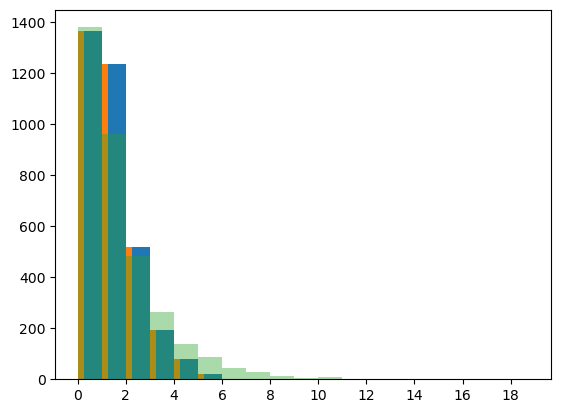

In [30]:
plt.hist(x = test_pred, bins=range(max(risk_df["acci_rate"])))
plt.hist(x = test_pred, bins=np.arange(0, max(risk_df["acci_rate"]), 0.25))
#plt.xticks(range(0, max(risk_df["acci_rate"]+1), 2))
#plt.show()

a = plt.hist(x = y_test, bins=range(max(risk_df["acci_rate"])), alpha=0.4)
plt.xticks(range(0, max(risk_df["acci_rate"]+1), 2))
plt.show()